In [1]:
import numpy as np
import torch
from torch import Tensor

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from itertools import chain
from healing_mnist import HealingMNIST

In [4]:
mnist = HealingMNIST()

X_train = Tensor(mnist.train_images.reshape(60000, 5, 784).astype(int))
U_train = Tensor(np.transpose(np.stack([np.sin((mnist.train_rotations / 180.) * np.pi * i) for i in range(25)] + [np.cos((mnist.train_rotations / 180.) * np.pi * i) for i in range(25)]), axes=[1, 2, 0]))

In [5]:
D = 784
dim = D
z_dim = 784

Sphi = torch.zeros((z_dim), requires_grad=True)
St = torch.zeros((z_dim), requires_grad=True) # varience of z

Fk = torch.nn.Sequential(
    torch.nn.Linear(z_dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(dim, dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(dim, dim),
    torch.nn.Sigmoid()
)

Gk = torch.nn.GRUCell(50, z_dim)

Q = torch.nn.Sequential(
    torch.nn.Linear(dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(dim, dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(dim, z_dim)
)

In [ ]:
from tqdm import tqdm_notebook

T = 5
delta = 1

optimizer = torch.optim.Adam(chain(Gk.parameters(), Fk.parameters(), Q.parameters(), [Sphi, St]), lr=1e-3)
l = []
lp = []
lt = []

for k in tqdm_notebook(range(1000)):
    
    batch_size = 30
    
    batch_x = X_train[(k%(len(X_train) // batch_size))::(len(X_train) // batch_size)] 
    batch_u = U_train[(k%(len(X_train) // batch_size))::(len(X_train) // batch_size)]
    
    sample_size = 20
    
    SphiPos = torch.exp(Sphi)
    StPos = torch.exp(St)

    logp = 0
    # logp += (T-1) * D * torch.log(delta) * torch.prod(St)
    logp -= T * torch.sum(torch.log(SphiPos))   # sum_t torch.log(torch.prod(Sphi))
    logp += torch.prod(SphiPos)  # trace of diag
    logp += (T - 1) * torch.prod(SphiPos / StPos)  # sum^T_t=2 trace(diag(St)^-1 @ diag(Sphi))
    
    
    mu_q_t = Q(batch_x)
    
    logp += torch.mean(torch.sum((mu_q_t[:, 0, :] * mu_q_t[:, 0, :]), dim=1))
    
    # shape [50, 5, 784], random
    sample_z = mu_q_t + (SphiPos * torch.normal(torch.zeros((sample_size, batch_size, 5, z_dim)), 
                                                torch.ones((sample_size, batch_size, 5, z_dim))))
    # shape [50, 4, 784], random
    Gt_t_2T = Gk(batch_u.unsqueeze(0).repeat(sample_size, 1, 1, 1).reshape(sample_size*batch_size*5, -1), 
                 sample_z.reshape(sample_size*batch_size*5, -1)).reshape(sample_size, batch_size, 5, -1)

    # 0.02 = (1/50) - averaging over random sample
    logp += (1./(sample_size * batch_size))*torch.sum(((Gt_t_2T[:, :, :4, :] - mu_q_t[:, 1:, :]) * 
                                                       (Gt_t_2T[:, :, :4, :] - mu_q_t[:, 1:, :]) / StPos))
    logp *= 0.5

    p = Fk(sample_z)
    loss = torch.nn.functional.binary_cross_entropy(input=p.reshape(-1, T*784), 
                                                    target=batch_x.unsqueeze(0).repeat(sample_size, 1, 1, 1).reshape(-1, T*784))
    
    total_loss = loss + logp 
    
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    l.append(loss.data)
    lt.append(total_loss.data)
    lp.append(logp.data)

In [ ]:
sample_z = mu_q_t + (SphiPos * torch.normal(torch.zeros((5, z_dim)), 
                                                torch.ones((5, z_dim))))
    

In [ ]:
mu_q_t.shape

In [ ]:
plt.plot(lt)

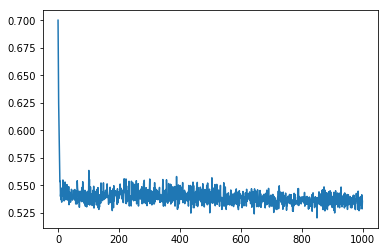

In [79]:
plt.plot(l)

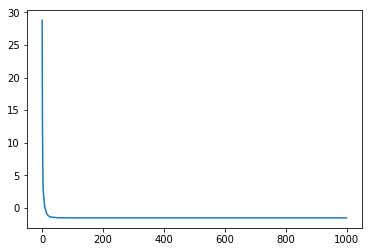

In [80]:
plt.plot(lp)

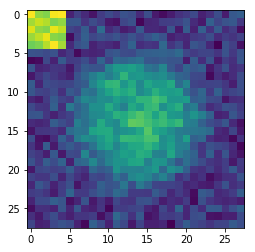

In [84]:
plt.imshow(Fk(Q(X_train[0]))[0].detach().reshape(28, 28))

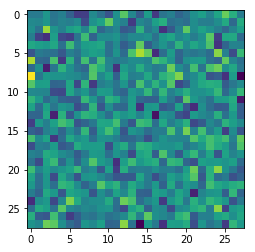

In [85]:
plt.imshow(Q(X_train[0]).detach()[0].reshape(28, 28))

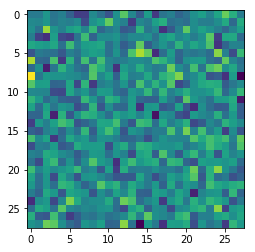

In [86]:
plt.imshow(Q(X_train[1]).detach()[0].reshape(28, 28))

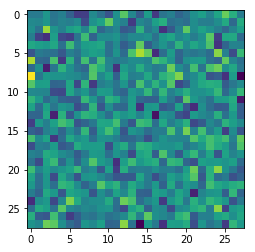

In [87]:
plt.imshow(Q(X_train[2]).detach()[0].reshape(28, 28))